
# <p style="padding:10px;background-color:#8B0000;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">"Patent Classifier: NLP-Driven Categorization Using EPO Scheme"</p>

 

### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Problem Statement</p>

#### Objective: Develop an NLP model to classify 59,119 patent abstracts into one of nine categories based on the European Patent Office (EPO) classification scheme:

- Categories: Include Human Necessities, Performing Operations; Transporting, Chemistry; Metallurgy, and others, encompassing a total of nine fields ranging up to General tagging of new or cross-sectional technology.
- Purpose: Enable automatic and efficient sorting of patent data to improve intellectual property management and support decision-making processes.

 

### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Problem Statement</p>


#### Data Dictionary:

Abstract (59119 rows): A summary of the patent.

Label (9 classes): The patent classification according to the European Patent Office (EPO) classification scheme.

#### Categories:

- 1 (Human Necessities),
- 2 (Performing Operations; Transporting),
- 3 (Chemistry; Metallurgy),
- 4 (Textiles; Paper),
- 5 (Fixed Constructions),
- 6 (Mechanical Engineering; Lightning; Heating; Weapons; Blasting),
- 7 (Physics),
- 8 (Electricity), and
- 9 (General tagging of new or cross-sectional technology)



In [1]:
#Importing necessary libraries
import re
import text_hammer as th
from wordcloud import WordCloud

import numpy as np 
import pandas as pd 
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from transformers import AutoTokenizer,TFBertModel

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

from sklearn.metrics import balanced_accuracy_score



In [2]:
import pandas as pd

# Load the dataset
data = pd.read_csv('train.csv')

# Display the first few rows of the dataset and its basic info
data.head(10)


,Label,Content
0,2,second counting input 5 2 which receives inter...
1,4,extremely low temperature of the chips in cold...
2,3,of the basic ammonium salt of the carboxyl ate...
3,9,18 u2033 is provided which is axially supporte...
4,2,to an u201c inner surface u201d means the surf...
5,2,dispenser 79 is completely opened the top can ...
6,7,strong and sharply defined magnetic fields ema...
7,7,the current in nmos transistor m 1 equals the ...
8,9,so the endophyte can be detected by this proce...
9,5,b is affixed by convenient means not shown to ...



### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">EDA</p>

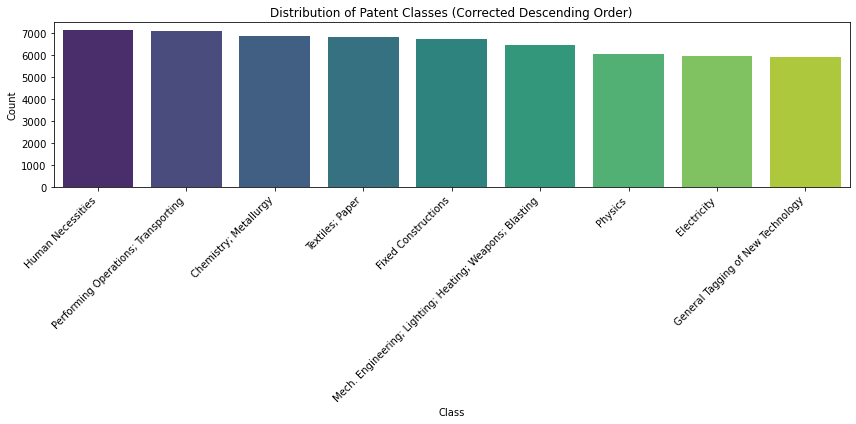

In [3]:
sorted_labels = data['Label'].value_counts().index

# Creating the plot with the corrected order
plt.figure(figsize=(12, 6))
sns.countplot(x='Label', data=data, order=sorted_labels, palette='viridis')
plt.title('Distribution of Patent Classes (Corrected Descending Order)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(0, 9), ['Human Necessities', 'Performing Operations; Transporting',
                         'Chemistry; Metallurgy', 'Textiles; Paper', 'Fixed Constructions',
                         'Mech. Engineering; Lighting; Heating; Weapons; Blasting',
                         'Physics', 'Electricity', 'General Tagging of New Technology'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


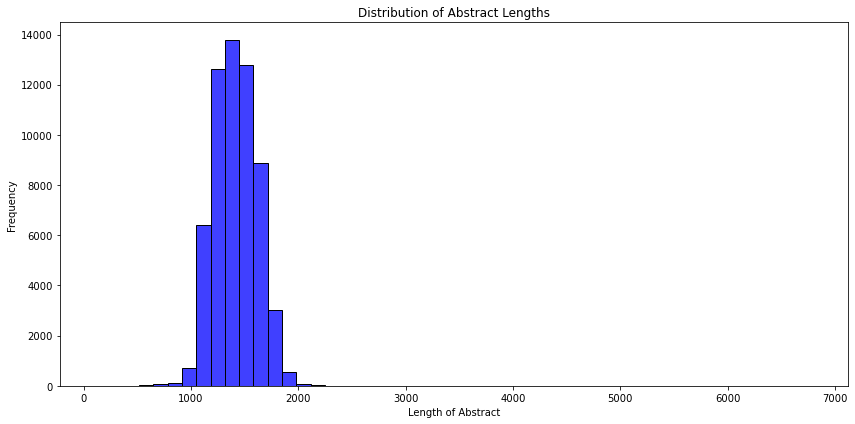

In [4]:
# Calculate the length of each abstract
data['Content_Length'] = data['Content'].apply(len)

# Visualize the distribution of abstract lengths
plt.figure(figsize=(12, 6))
sns.histplot(data['Content_Length'], bins=50, color='blue')
plt.title('Distribution of Abstract Lengths')
plt.xlabel('Length of Abstract')
plt.ylabel('Frequency')
plt.tight_layout()

plt.show()


### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Text Cleaning Preprocessing</p>

In [5]:

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenization (splitting text into words)
    words = text.split()
    # Stop word removal
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

# Apply preprocessing to the abstracts
data['Processed_Content'] = data['Content'].apply(preprocess_text)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cyril\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cyril\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
data.head(10)

,Label,Content,Content_Length,Processed_Content
0,2,second counting input 5 2 which receives inter...,1505,second counting input receives internally cont...
1,4,extremely low temperature of the chips in cold...,1252,extremely low temperature chip cold season chi...
2,3,of the basic ammonium salt of the carboxyl ate...,1346,basic ammonium salt carboxyl ate water soluble...
3,9,18 u2033 is provided which is axially supporte...,1570,u provided axially supported crankshaft via ra...
4,2,to an u201c inner surface u201d means the surf...,1734,uc inner surface ud mean surface layer away ou...
5,2,dispenser 79 is completely opened the top can ...,1289,dispenser completely opened top c fall basket ...
6,7,strong and sharply defined magnetic fields ema...,1288,strong sharply defined magnetic field emanatin...
7,7,the current in nmos transistor m 1 equals the ...,1576,current nmos transistor equal sum current ntmo...
8,9,so the endophyte can be detected by this proce...,1699,endophyte detected procedure result neotyphodi...
9,5,b is affixed by convenient means not shown to ...,1179,b affixed convenient mean shown source shown o...


In [7]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Processed_Content'], data['Label'], test_size=0.18, random_state=42)



In [8]:
X_train.shape

(48477,)


### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Model Pipeline using TF-IDF</p>

In [9]:
# Creating a pipeline with TF-IDF Vectorizer and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])

# Training the model
pipeline.fit(X_train, y_train)

# Predicting the test set
y_pred = pipeline.predict(X_test)

# Evaluating the model
evaluation_report = classification_report(y_test, y_pred, output_dict=True)

# Return the evaluation report
evaluation_report


{'1': {'precision': 0.5794732061762035,
  'recall': 0.5182778229082047,
  'f1-score': 0.5471698113207547,
  'support': 1231},
 '2': {'precision': 0.41241496598639454,
  'recall': 0.4072208228379513,
  'f1-score': 0.40980143641740596,
  'support': 1191},
 '3': {'precision': 0.6113099498926271,
  'recall': 0.7625,
  'f1-score': 0.678585617798967,
  'support': 1120},
 '4': {'precision': 0.7300194931773879,
  'recall': 0.6535776614310645,
  'f1-score': 0.6896869244935543,
  'support': 1146},
 '5': {'precision': 0.5689922480620155,
  'recall': 0.642169728783902,
  'f1-score': 0.603370324702014,
  'support': 1143},
 '6': {'precision': 0.5054421768707483,
  'recall': 0.6238455079764903,
  'f1-score': 0.5584366779406239,
  'support': 1191},
 '7': {'precision': 0.5211678832116788,
  'recall': 0.5734939759036145,
  'f1-score': 0.5460803059273422,
  'support': 1245},
 '8': {'precision': 0.5930984902947519,
  'recall': 0.637065637065637,
  'f1-score': 0.6142963514519731,
  'support': 1295},
 '9': 

In [10]:

# Calculate balanced accuracy score
balanced_acc_lgr = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy Score (Decision Tree):", balanced_acc_lgr)

Balanced Accuracy Score (Decision Tree): 0.543477700561668



### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Logistic Regression</p>

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Updating the pipeline with the specified hyperparameters
pipeline_updated = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 1))),
    ('clf', LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=1000))
])

# Training the model with the updated pipeline
pipeline_updated.fit(X_train, y_train)

# Predicting the test set with the updated model
y_pred_updated = pipeline_updated.predict(X_test)

# Evaluating the updated model
evaluation_report_updated = classification_report(y_test, y_pred_updated, output_dict=True)


# Calculate balanced accuracy score
balanced_acc_upddated = balanced_accuracy_score(y_test, y_pred_updated)
print("Balanced Accuracy Score (Decision Tree):", balanced_acc_upddated)


Balanced Accuracy Score (Decision Tree): 0.5576465099755342



### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">LightGBM</p>

In [12]:
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, balanced_accuracy_score

# Vectorize the text
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
X_test_vec = tfidf_vectorizer.transform(X_test)

# Initialize the LightGBM classifier
lgbm_classifier = LGBMClassifier()

# Train the LightGBM classifier
lgbm_classifier.fit(X_train_vec, y_train)

# Predict the test set
y_pred_lgbm = lgbm_classifier.predict(X_test_vec)

# Evaluate the model
evaluation_report_lgbm = classification_report(y_test, y_pred_lgbm, output_dict=True)

# Calculate balanced accuracy score
balanced_acc_lgbm = balanced_accuracy_score(y_test, y_pred_lgbm)

# Print the balanced accuracy score
print("Balanced Accuracy Score (LightGBM):", balanced_acc_lgbm)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.795579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 580344
[LightGBM] [Info] Number of data points in the train set: 48477, number of used features: 4999
[LightGBM] [Info] Start training from score -2.171806
[LightGBM] [Info] Start training from score -2.153869
[LightGBM] [Info] Start training from score -2.283927
[LightGBM] [Info] Start training from score -2.316231
[LightGBM] [Info] Start training from score -2.208865
[LightGBM] [Info] Start training from score -2.141325
[LightGBM] [Info] Start training from score -2.106476
[LightGBM] [Info] Start training from score -2.122025
[LightGBM] [Info] Start training from score -2.295739
Balanced Accuracy Score (LightGBM): 0.554390567563567
